## Data prep

* original_embeddings: 1854 concepts * 49 features (euclidean)
* memorability scores
* category mappings: 1324 concepts in 27 higher-level categories
* feature names
* typicality scores: average similarity of 1619 concepts within category


In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.linalg import orthogonal_procrustes
import statsmodels.api as sm
import scipy.stats as stats
from hyperbolicMDS.mds import HyperMDS, cart_to_polar
from matplotlib import colors
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import re, seaborn as sns

data_dir = '../data'
output_dir = '../albatross_49_7D/outputs'

In [2]:
# load original 1854*49 embeddings
original_embeddings = np.loadtxt(os.path.join(data_dir, 'spose_embedding_49d_sorted.txt'))
original_embeddings.shape

(1854, 49)

In [3]:
# load categories and memorability score of each concept
cat_mapping = pd.read_csv(os.path.join(data_dir, 'THINGS_Table.csv'))
cat_concept_mem = cat_mapping[['cr', 'smallcat', 'bigcat']].groupby('smallcat').mean()
cat_concept_mem['bigcat'] = cat_concept_mem['bigcat'].astype(int).replace(0, 99)
cat_concept_mem

,cr,bigcat
smallcat,,
1,0.779739,1
2,0.798485,13
3,0.752845,18
4,0.761851,99
5,0.794466,9
...,...,...
1850,0.722655,99
1851,0.843158,10
1852,0.800163,1


In [4]:
### load category names and merge with concepts
cat = loadmat(os.path.join(data_dir,'categories.mat'))
cat_names = [item[0] for item in cat['categories'][0]]
cat_names.append('na')
cat_names = pd.DataFrame(cat_names, columns=['cat_name']).reset_index()
cat_names['index'] = cat_names['index']+1
cat_names.iloc[27] = [99, np.nan]
cat_concept_mem = cat_concept_mem.merge(cat_names, how='left', left_on='bigcat', right_on='index').drop(columns=['index'])
cat_concept_mem


,cr,bigcat,cat_name
0,0.779739,1,animal
1,0.798485,13,home decor
2,0.752845,18,musical instrument
3,0.761851,99,NaN
4,0.794466,9,electronic device
...,...,...,...
1849,0.722655,99,NaN
1850,0.843158,10,food
1851,0.800163,1,animal
1852,0.797468,99,NaN


In [5]:
### load feature names
feat_short = loadmat(os.path.join(data_dir, 'labels_short.mat'))
feat_short_names = [item[0] for item in feat_short['labels_short'][0]]
features = loadmat(os.path.join(data_dir, 'labels.mat'))
feat_name = [item[0][0] for item in features['labels']]
feat_name

['made of metal / artificial / hard',
 'food-related / eating-related / kitchen-related',
 'animal-related / organic',
 'clothing-related / fabric / covering',
 'furniture-related / household-related / artifact',
 'plant-related / green',
 'outdoors-related',
 'transportation / motorized / dynamic',
 'wood-related / brownish',
 'body part-related',
 'colorful',
 'valuable / special occasion-related',
 'electronic / technology',
 'sport-related / recreational activity-related',
 'disc-shaped / round',
 'tool-related',
 'many small things / course pattern',
 'paper-related / thin / flat / text-related',
 'fluid-related / drink-related',
 'long / thin',
 'water-related / blue',
 'powdery / fine-scale pattern',
 'red',
 'feminine (stereotypically) / decorative',
 'bathroom-related / sanitary',
 'black / noble',
 'weapon / danger-related / violence',
 'musical instrument-related / noise-related',
 'sky-related / flying-related / floating-related',
 'spherical / ellipsoid / rounded / volumin

In [6]:
### load typicality score and merge with concepts
cat_typicality = loadmat(os.path.join(data_dir, 'typicality_data27.mat'))
concept_idx = []
concept_typ = []
concept_cat = []
for cat_idx in range(27):
    concept_idx.extend(pd.DataFrame(cat_typicality['category27_ind'][0][cat_idx])[0].to_list())
    concept_typ.extend(pd.DataFrame(cat_typicality['category27_typicality_rating_normed'][cat_idx][0])[0].to_list())
    concept_cat.extend([cat_idx+1 for i in range(len(cat_typicality['category27_ind'][0][cat_idx]))])
concept_typicality_rated = pd.DataFrame({'cat': concept_cat, 'concept': concept_idx, 'typicality': concept_typ})
concept_typicality_rated['concept'] = concept_typicality_rated['concept']-1
concept_typicality_rated

,cat,concept,typicality
0,1,0,4.874352
1,1,12,6.374555
2,1,15,5.342846
3,1,24,4.655669
4,1,25,5.288886
...,...,...,...
1614,27,1602,7.456293
1615,27,1620,5.922099
1616,27,1684,5.219242
1617,27,1712,3.238293


## 49-dim Feature Space

1. Get 49-dim feature embeddings from albatross results (.npy)
2. Get loadings of 1854 concepts in 49-dim hyperbolic feature space
3. Euclidean vs. mobius vector addition: test out different values of S
4. Get average 49-dim feature space embeddings and 1854 concept loadings through procrustes
5. Analysis: predicting memorability (euclidean vs. mobius)
    * Cartesian coordinates (x, y, z: which axis explains variances in memorability the best)
    * Polar coordinates (r, theta, rho: which angle explains the best)
    * Radius (concepts closer to the core vs. on surface are more memorable?)
    * K-Means clusters:
      - Cartesian coordinates
      - Polar coordinates
6. Analysis: with typicality (euclidean vs. mobius)
    * Calculate typicality: average similarity of each concept pair within category 
    * Predicting typicality
      - Cartesian coordinates
      - Polar coordinates 
      - Radius
    * Predicting memorability
      - Typicality (more prototypical --> more memorable?)
      - Typicality + coordinates/radius to predict memorability
        



In [7]:
### stack albatross outputs
output_dir = '../albatross_49_7D/outputs'
# embeddings = []
# for i in range(10):
#     tmp = np.load(os.path.join(output_dir, f'membatross_embeddings_49_7D_{i}.npy'))
#     embeddings.append(tmp)
# embeddings = np.dstack(embeddings)
# np.save(os.path.join(output_dir, 'membatross_embeddings_49_7D.npy'), embeddings)

In [8]:
# 49-dim feature space embeddings
feature_embeddings = np.load(os.path.join(output_dir, 'membatross_embeddings_49_7D.npy'))
feature_embeddings.shape

(49, 7, 500)

1. `feature_embeddings`: output of ALBATROSS, embbeddings of 49 features that represent where 49 features locate in the 3D hyperbolic space. 
2. By multiplying `original_embeddings` (representations of 1854 concepts in 49-dim euclidean feature space) with `feature_embeddings`, we got `concept_in_feat_coord` that contains the loadings of 1854 concepts in hyperbolic space.
3. Instead of euclidean matrix multiplication (sum of loading * each feature vector), we used einstein scalar multiplication and mobius gyrovetor addition to transform 1854 concepts loadings from 49 feature dimensional space to 3d hyperbolic space. By doing this, loadings on each feature vector were multiplied and added in hyperbolic way, where the parameter S controlled the maximum length of vector (max radius of hyperbolic space).

In [9]:
### normalize embeddings and transform concept embeddings to loadings in hyperbolic feature space
concept_in_feat_coord = []
normalized_embeddings = (original_embeddings.T/np.sqrt((original_embeddings**2).sum(axis=1))).T
for layer in range(feature_embeddings.shape[-1]):
    concept_in_feat_coord.append(normalized_embeddings@feature_embeddings[:,:,layer])
np.array(concept_in_feat_coord).shape

(500, 1854, 7)

Orthogonal procrustes looped through each layer and rotated them so that all layers closely mapped. 

In [10]:
### procrustes of concept loadings in hyperbolic feature space
concept_in_feat_reference = concept_in_feat_coord[0]
concept_in_feat_output = [concept_in_feat_reference]
for i in range(1, len(concept_in_feat_coord)):
    R, scale = orthogonal_procrustes(concept_in_feat_coord[i], concept_in_feat_reference)
    concept_in_feat_output.append(concept_in_feat_coord[i]@R)
concept_in_feat_reference

array([[-3.26792614, -2.10916811,  1.6720235 , ...,  4.45815671,
         4.29610789, -4.43424062],
       [ 2.53856057, -1.19075495,  1.47736327, ...,  1.34231761,
         7.12864425,  4.2501037 ],
       [ 4.0403643 ,  5.94522906, -3.43406271, ..., -1.45304467,
         1.99999412, -1.75463499],
       ...,
       [-1.48234246, -2.44996981,  0.60489826, ...,  4.923402  ,
         3.07173105, -4.25152585],
       [-3.30517999,  1.33913067,  5.84271544, ...,  5.54251769,
         0.30463878, -6.07092951],
       [ 4.10624863,  2.49714216,  6.72934754, ..., -3.15576921,
         1.07887264, -0.3114355 ]])

In [11]:
### procrustes of feature embeddings
feature_embed_reference = feature_embeddings[:,:,0]
feature_embed_output = [feature_embed_reference]
for i in range(1, feature_embeddings.shape[-1]):
    R, scale = orthogonal_procrustes(feature_embeddings[:,:,i], feature_embed_reference)
    feature_embed_output.append(feature_embeddings[:,:,i]@R)

In [12]:
### average across 500 layers
mean_concept_in_feat = np.array(concept_in_feat_output).mean(axis=0)
mean_feature_embed = np.array(feature_embed_output).mean(0)

In [13]:
### merge concept loadings with category and memorability
mean_concept_in_feat_cat = pd.DataFrame(mean_concept_in_feat).reset_index().merge(cat_concept_mem, how='left', left_on='index', right_index=True)
mean_concept_in_feat_cat_na = mean_concept_in_feat_cat.dropna()
mean_concept_in_feat_cat_na

,index,0,1,2,3,4,5,6,cr,bigcat,cat_name
0,0,-1.751975,-1.363491,2.754878,-2.003441,2.170470,4.346833,-1.038244,0.779739,1,animal
1,1,3.366486,-1.551474,4.936362,-3.419526,1.502132,1.765430,-1.031116,0.798485,13,home decor
2,2,3.898466,1.861650,3.624984,-3.814992,2.098648,1.174099,-3.643279,0.752845,18,musical instrument
4,4,1.831190,-2.091916,4.408287,-1.705511,3.830130,-1.554478,-3.292011,0.794466,9,electronic device
5,5,2.886399,0.332521,6.331749,-1.816420,2.724919,-1.365519,-5.326400,0.806000,12,furniture
...,...,...,...,...,...,...,...,...,...,...,...
1847,1847,1.715731,-1.132884,4.473116,-2.123677,-0.081708,0.951165,-3.314085,0.803129,24,toy
1848,1848,3.025967,-1.125249,6.287917,-3.496768,-2.673139,-2.081659,0.597797,0.765881,10,food
1850,1850,2.444899,-1.504380,7.415873,-2.633943,-3.597824,-0.886195,0.953933,0.843158,10,food
1851,1851,-0.284350,-2.111643,3.449401,-2.042666,3.457406,3.676994,-2.580821,0.800163,1,animal


<IPython.core.display.Javascript object>


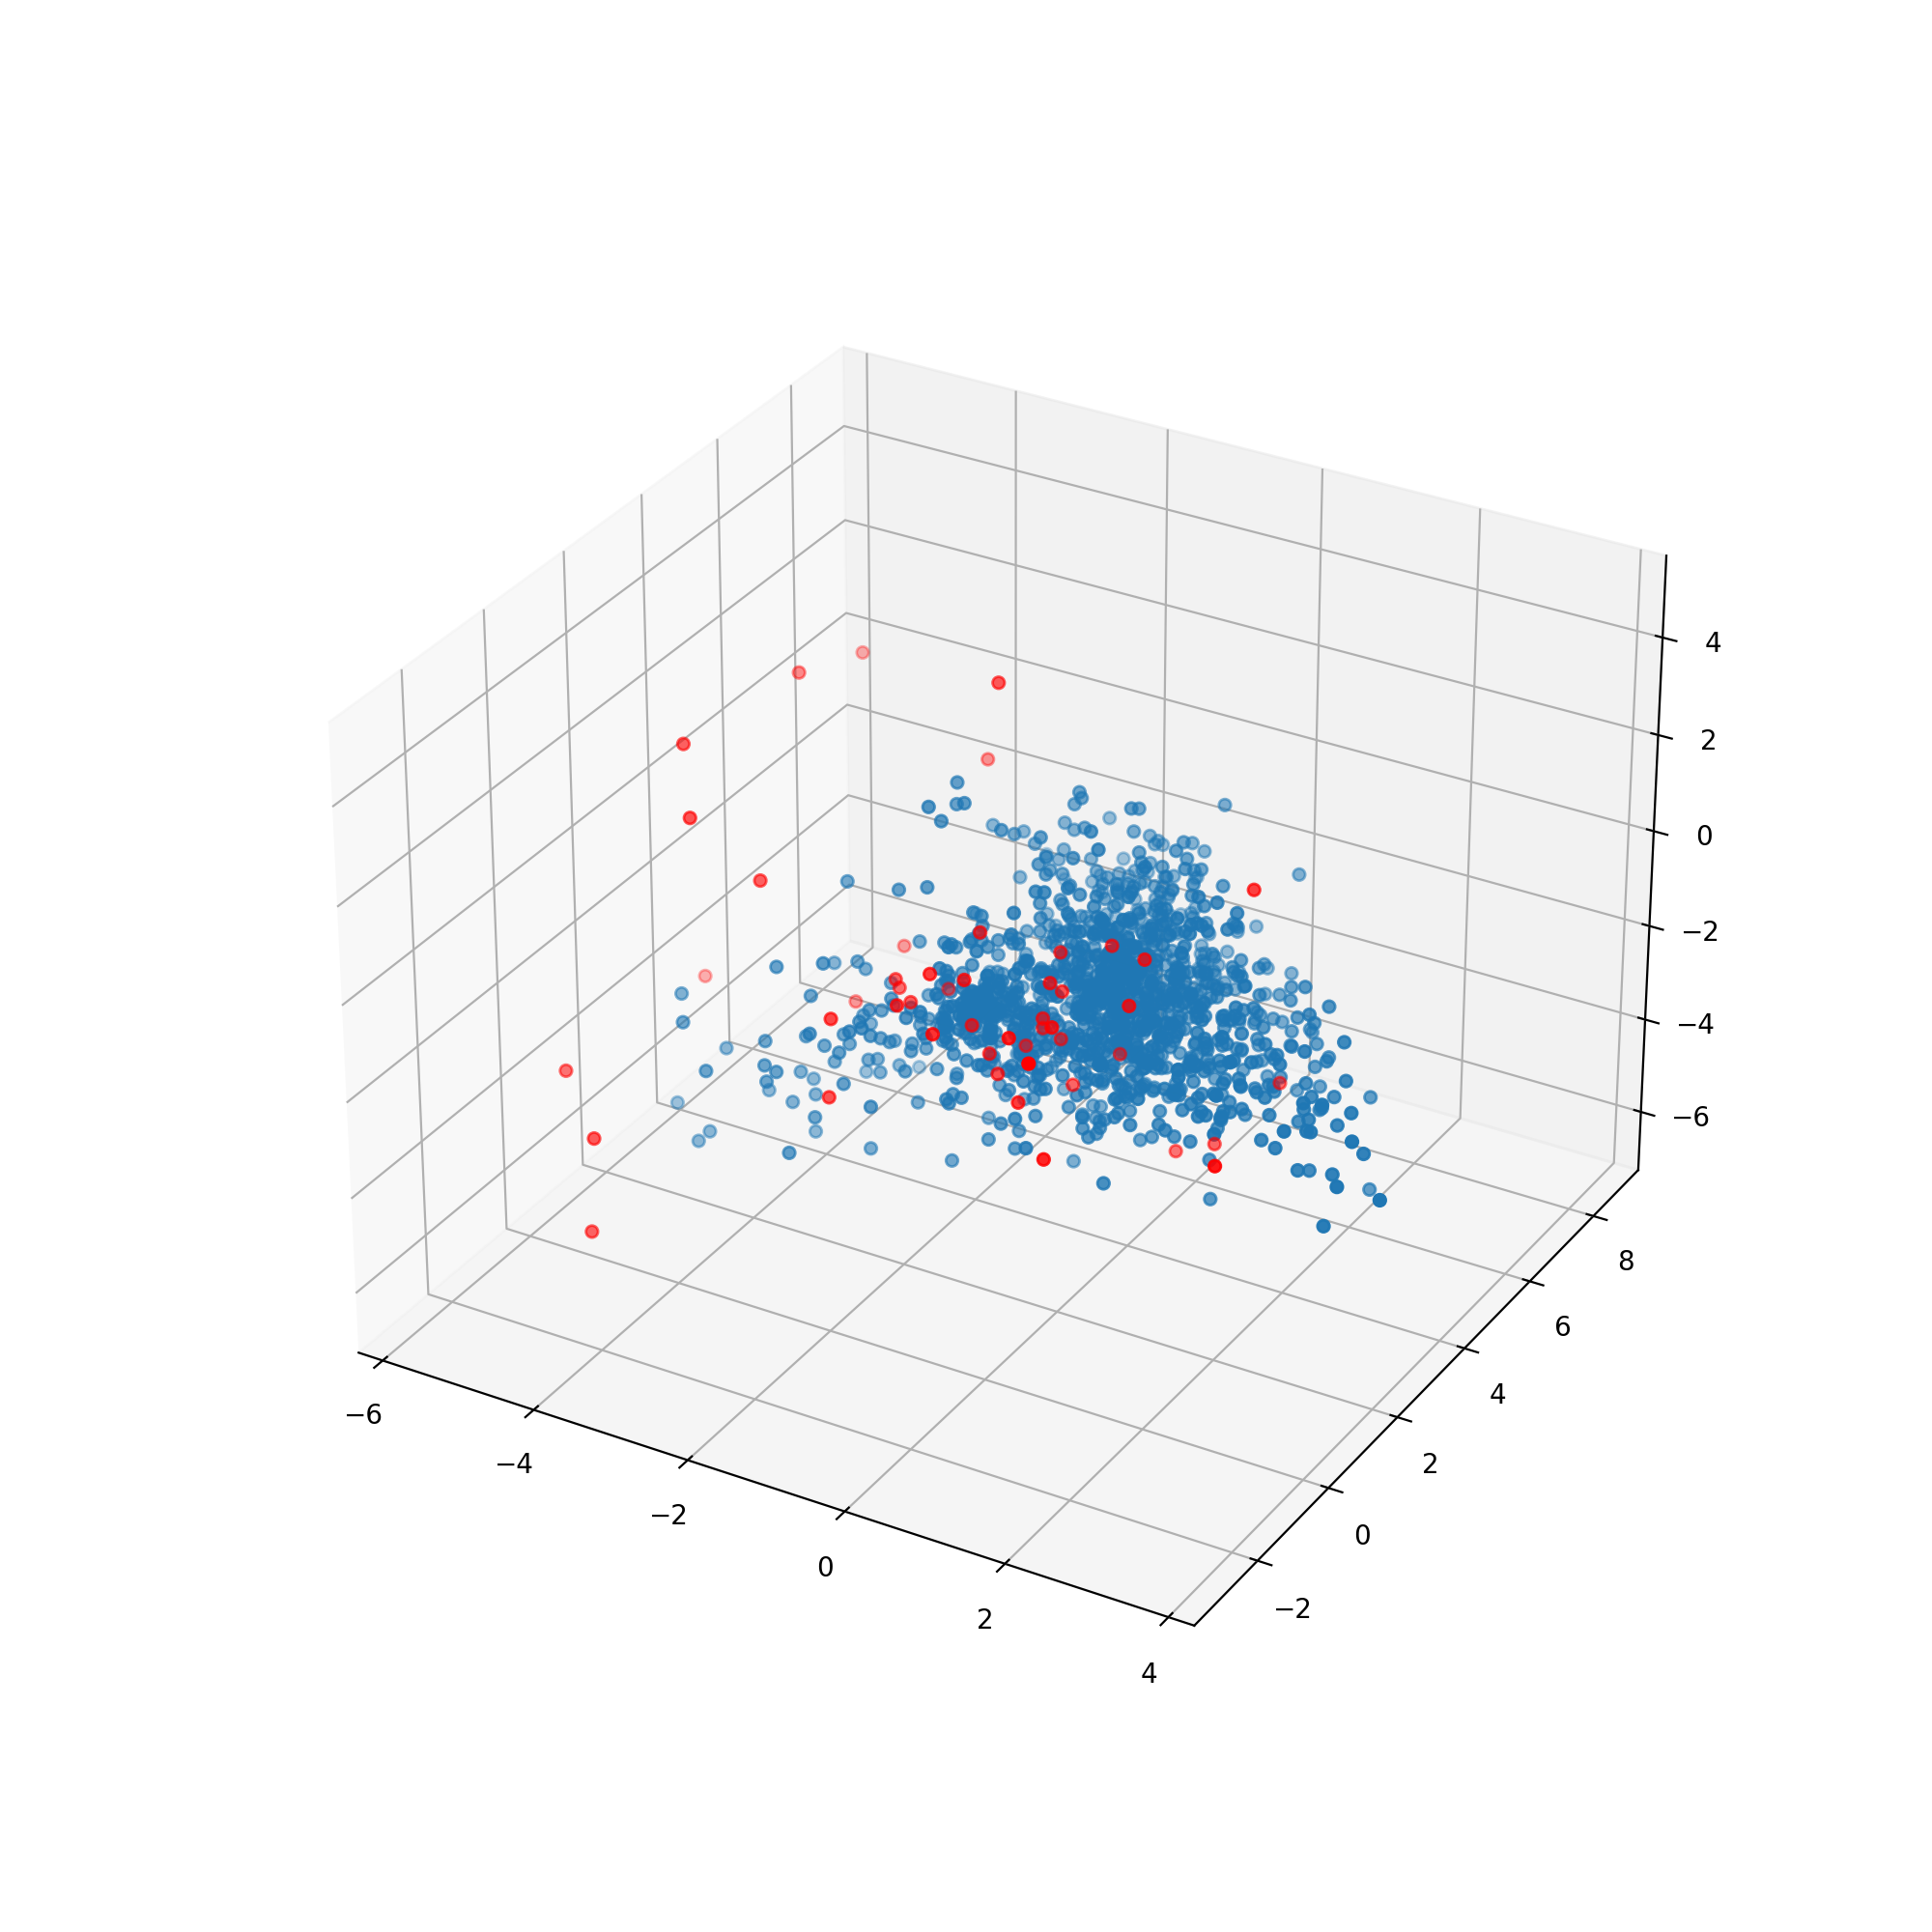

In [14]:
%matplotlib notebook

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

concept_cat = ax.scatter(mean_concept_in_feat_cat_na[1], mean_concept_in_feat_cat_na[2], mean_concept_in_feat_cat_na[3]) 

ax.scatter(mean_feature_embed.T[1], mean_feature_embed.T[2], mean_feature_embed.T[3], color='red')

plt.show()

### Analysis: coordinates vs. memorability

#### Cartesian coordinates
Cartesian coordinates of concepts explained 9.8% of variance in memorability, where x axis is most influential in memorability, while memorability decreased as coordinates going positively along y and z axes. 

In [15]:
### linreg: cartesian coordinates and z-score memorability
# normalized: R^2 = 0.098, adjusted = 0.096
# mobius: R^2 = 0.072, adjusted = 0.06
# mobius (S=48): R^2 = 0.117
import statsmodels.api as sm
import scipy.stats as stats

zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_constant = sm.add_constant(mean_concept_in_feat_cat[[0,1,2,3,4,5,6]], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     52.11
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           4.64e-68
Time:                        07:48:44   Log-Likelihood:                -2463.6
No. Observations:                1854   AIC:                             4943.
Df Residuals:                    1846   BIC:                             4987.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1564      0.015    -10.654      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [16]:
### create a new table to store all regression results
results_index = ['rsquared', 'rsquared_adj', 'coef', 'pvalues', 'AIC', 'BIC', 'F-statistic', 'F-stats-prob', 'Log-Likelihood']
results = pd.DataFrame({'cart_coord_mem':[res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]}, index=results_index)
results

,cart_coord_mem
rsquared,0.164986
rsquared_adj,0.161819
coef,"[-0.15635448660778506, 0.14043065554553524, -0..."
pvalues,"[9.246329216875562e-26, 1.5333962910304059e-15..."
AIC,4943.136019
BIC,4987.336825
F-statistic,52.105788
F-stats-prob,0.0
Log-Likelihood,-2463.56801


#### Polar coordinates
Predicting memorability using polar coordinates: polar coordinates explained less variance in memorability than cartesian coordinates. Vertical angle of concepts in the hyperbolic space is the most influential variable in predicting memorability, where concepts closer to the core are more memorable, and concepts closer to the ceiling/floor of the space are more forgettable. 

In [17]:
### Polar coordinates of concepts in hyperbolic feature space
# r, theta, rho = cart_to_polar(mean_concept_in_feat_cat[[0,1,2,3]].values).T
# plt.hist2d(theta, rho,
#            bins = 20)

In [18]:
### linreg: polar coordinates vs. memorability
# normalized: R^2 = 0.074, adjusted = 0.072
# mobius: R^2 = 0.019, adjusted = 0.018
# mobius (S=48): R^2 = 0.091

# zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
# mean_concept_constant = sm.add_constant(np.array([r, theta, rho]).T, prepend=False)
# mod = sm.OLS(zscore_mem, mean_concept_constant)

# res = mod.fit()
# print(res.summary())

#### Radius
Predicting memorability using radius: radius of concepts in the hyperbolic space explained even smaller variance in memorability. Concepts that have shorter radius are closer to the core of the space and are more memorable. 

<IPython.core.display.Javascript object>


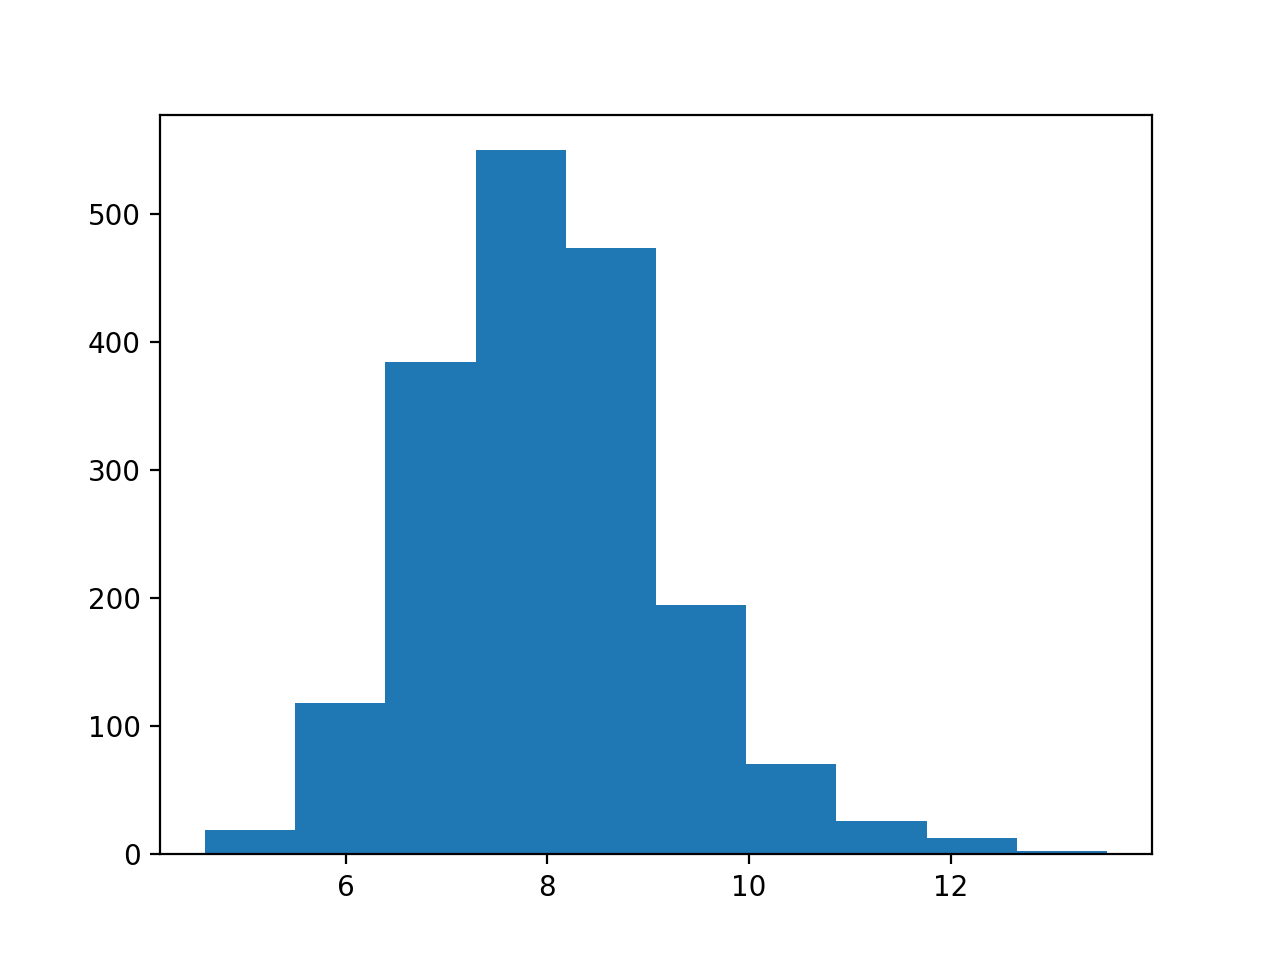

(array([ 19., 118., 385., 550., 474., 195.,  71.,  26.,  13.,   3.]),
 array([ 4.60601747,  5.50022154,  6.39442562,  7.28862969,  8.18283377,
         9.07703784,  9.97124191, 10.86544599, 11.75965006, 12.65385414,
        13.54805821]),
 <BarContainer object of 10 artists>)

In [19]:
### Radius
%matplotlib notebook
import matplotlib.pyplot as plt
concept_radius_in_feat = np.sqrt((mean_concept_in_feat_cat[[0,1,2,3,4,5,6]]**2).sum(1))

plt.clf()
plt.hist(concept_radius_in_feat)

In [20]:
### Radius vs. memorability
# normalized: R^2 = 0.037, adjusted = 0.037
# mobius: R^2 = 0.014, adjusted = 0.013
zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_radius_const = sm.add_constant(concept_radius_in_feat, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_radius_const)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     7.896
Date:                Thu, 06 Oct 2022   Prob (F-statistic):            0.00501
Time:                        07:48:57   Log-Likelihood:                -2626.8
No. Observations:                1854   AIC:                             5258.
Df Residuals:                    1852   BIC:                             5269.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0537      0.019      2.810      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [21]:
results['radius_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]
results

,cart_coord_mem,radius_mem
rsquared,0.164986,0.004245
rsquared_adj,0.161819,0.003707
coef,"[-0.15635448660778506, 0.14043065554553524, -0...","[0.053717215989372374, -0.43105049099417936]"
pvalues,"[9.246329216875562e-26, 1.5333962910304059e-15...","[0.005007722558096661, 0.005518805684051779]"
AIC,4943.136019,5257.536799
BIC,4987.336825,5268.587001
F-statistic,52.105788,7.895556
F-stats-prob,0.0,0.005008
Log-Likelihood,-2463.56801,-2626.7684


#### K-Means
Concepts further away from the core are more memorable in all 4 clusters. Vertical angle has most significantly negative relation with memorability, showing that concepts that are vertically further away from origin are more forgettable. 

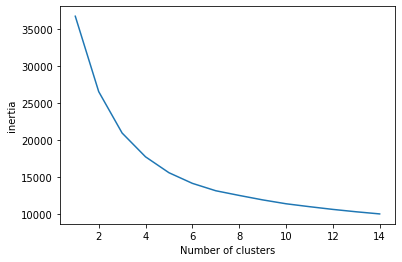

In [22]:
import math

inertia = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(mean_concept_in_feat_cat[[0,1,2,3,4,5,6]])
#     print(kmeans.inertia_)
    inertia.append(kmeans.inertia_)

%matplotlib inline
plt.plot(range(1, 15), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('inertia') 
plt.show()

In [23]:
### K-Means clustering on concepts
kmeans = KMeans(n_clusters=4, random_state=42).fit(mean_concept_in_feat_cat[[0,1,2,3,4,5,6]])
labels = kmeans.labels_
concept_coord_cluster = mean_concept_in_feat_cat
concept_coord_cluster['label'] = labels
kmeans.cluster_centers_


array([[-0.18429787, -1.95112879,  3.32869432, -3.28097664,  2.259632  ,
         4.11384298, -2.2998591 ],
       [ 2.9600379 , -0.97315189,  6.13129777, -3.25150598, -2.02235606,
        -1.21965996,  0.20963422],
       [ 2.5956742 , -0.83540476,  4.75328111, -3.24941014,  2.0308204 ,
         0.81118007, -2.21763572],
       [ 1.40341687, -0.47020337,  5.02948263, -2.3027157 ,  1.94508206,
        -1.24625329, -5.05831965]])

In [171]:
# ### clusters by memorability and plot concept coordinates in feature space
# %matplotlib notebook


# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')

# ax.scatter(mean_concept_in_feat_cat[0], mean_concept_in_feat_cat[1], mean_concept_in_feat_cat[2], c=labels, alpha=0.5)


In [24]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[[0,1,2,3,4,5,6]], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     17.46
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           6.46e-18
Time:                        07:49:15   Log-Likelihood:                -241.41
No. Observations:                 205   AIC:                             498.8
Df Residuals:                     197   BIC:                             525.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.2000      0.065     -3.092      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [25]:
### cluster 0: polar coordinates vs. memorability
polar_cluster_0 = cart_to_polar(cluster_0[[0,1,2,3,4,5,6]].values) - cart_to_polar(concept_coord_cluster[[0,1,2,3,4,5,6]].values).mean(0)
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_0, prepend=False)
mod_pol_0 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_0 = mod_pol_0.fit()
print(res_pol_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     17.42
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           6.98e-18
Time:                        07:49:22   Log-Likelihood:                -241.50
No. Observations:                 205   AIC:                             499.0
Df Residuals:                     197   BIC:                             525.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2105      0.076     -2.754      0.0

In [26]:
### cluster 0: radius vs. memorability
radius_0 = np.sqrt((cluster_0[[0,1,2,3,4,5,6]]**2).sum(1))
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_0, prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     37.18
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           5.35e-09
Time:                        07:49:26   Log-Likelihood:                -273.64
No. Observations:                 205   AIC:                             551.3
Df Residuals:                     203   BIC:                             557.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3525      0.058     -6.097      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [27]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[[0,1,2,3,4,5,6]], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     7.646
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           1.28e-08
Time:                        07:49:33   Log-Likelihood:                -500.91
No. Observations:                 371   AIC:                             1018.
Df Residuals:                     363   BIC:                             1049.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.4391      0.090      4.870      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [28]:
### cluster 1: polar coordinates vs. memorability
polar_cluster_1 = cart_to_polar(cluster_1[[0,1,2,3,4,5,6]].values) - cart_to_polar(concept_coord_cluster[[0,1,2,3,4,5,6]].values).mean(0)
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_1, prepend=False)
mod_pol_1 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_1 = mod_pol_1.fit()
print(res_pol_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     6.254
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           6.16e-07
Time:                        07:49:38   Log-Likelihood:                -505.30
No. Observations:                 371   AIC:                             1027.
Df Residuals:                     363   BIC:                             1058.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1688      0.071      2.391      0.0

In [29]:
### cluster 1: radius vs. memorability
radius_1 = np.sqrt((cluster_1[[0,1,2,3,4,5,6]]**2).sum(1))
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_1, prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     5.952
Date:                Thu, 06 Oct 2022   Prob (F-statistic):             0.0152
Time:                        07:49:41   Log-Likelihood:                -523.46
No. Observations:                 371   AIC:                             1051.
Df Residuals:                     369   BIC:                             1059.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1673      0.069      2.440      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [30]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[[0,1,2,3,4,5,6]], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     8.818
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           1.70e-10
Time:                        07:49:47   Log-Likelihood:                -1178.9
No. Observations:                 852   AIC:                             2374.
Df Residuals:                     844   BIC:                             2412.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0897      0.033      2.697      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [31]:
### cluster 2: polar coordinates vs. memorability
polar_cluster_2 = cart_to_polar(cluster_2[[0,1,2,3,4,5,6]].values) - cart_to_polar(concept_coord_cluster[[0,1,2,3,4,5,6]].values).mean(0)
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_2, prepend=False)
mod_pol_2 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_2 = mod_pol_2.fit()
print(res_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     7.200
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           2.17e-08
Time:                        07:49:53   Log-Likelihood:                -1184.2
No. Observations:                 852   AIC:                             2384.
Df Residuals:                     844   BIC:                             2422.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0379      0.030      1.261      0.2

In [32]:
### cluster 2: radius vs. memorability
radius_2 = np.sqrt((cluster_2[[0,1,2,3,4,5,6]]**2).sum(1))
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_2, prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.079
Date:                Thu, 06 Oct 2022   Prob (F-statistic):              0.299
Time:                        07:49:58   Log-Likelihood:                -1208.4
No. Observations:                 852   AIC:                             2421.
Df Residuals:                     850   BIC:                             2430.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0305      0.029      1.039      0.2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [33]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[[0,1,2,3,4,5,6]], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     30.93
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           1.77e-34
Time:                        07:50:02   Log-Likelihood:                -515.57
No. Observations:                 426   AIC:                             1047.
Df Residuals:                     418   BIC:                             1080.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1249      0.032     -3.862      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [34]:
### cluster 3: polar coordinates vs. memorability
polar_cluster_3 = cart_to_polar(cluster_3[[0,1,2,3,4,5,6]].values) - cart_to_polar(concept_coord_cluster[[0,1,2,3,4,5,6]].values).mean(0)
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_3, prepend=False)
mod_pol_3 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_3 = mod_pol_3.fit()
print(res_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     29.04
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           1.31e-32
Time:                        07:50:10   Log-Likelihood:                -520.07
No. Observations:                 426   AIC:                             1056.
Df Residuals:                     418   BIC:                             1089.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0224      0.031     -0.729      0.4

In [35]:
### cluster 3: radius vs. memorability
radius_3 = np.sqrt((cluster_3[[0,1,2,3,4,5,6]]**2).sum(1))
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_3, prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     7.325
Date:                Thu, 06 Oct 2022   Prob (F-statistic):            0.00707
Time:                        07:50:13   Log-Likelihood:                -600.82
No. Observations:                 426   AIC:                             1206.
Df Residuals:                     424   BIC:                             1214.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0934      0.035     -2.707      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [60]:
# ### Memorability changes by coordinates in each cluster
# # normalized: highest R^2 (cluster 1) = 0.318
# # mobius: highest R^2 (cluster 3) = 0.123

# %matplotlib notebook

# # plt.clf()
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')

# ax.scatter(cluster_0[0], cluster_0[1], cluster_0[2], label='cluster_0', alpha=0.3)
# # ax.plot(np.linspace(-30,-20,100), np.linspace(10,20,100), -2.5+-.5+np.linspace(-30,-20,100)*.0057+ np.linspace(10,20,100)*.0509+ np.linspace(-7.5, 2.5, 100)*.0108, label='cluster_0', alpha=1)
# # ax.plot(np.linspace(-15,-5,100), np.linspace(5,15,100), -.3135+np.linspace(-15,-5,100)*.1324+ np.linspace(5,15,100)*.1098+ np.linspace(-5, 5, 100)*-.0734, label='cluster_0', alpha=1)
# ax.quiver(-30, 10, -7.5, 10, 10, 10, length = 10, normalize = True, color='blue')


# # c0_grid = np.meshgrid(np.linspace(-20,-30,100), np.linspace(10,20,100))
# # ax.plot_surface(c0_grid[0], c0_grid[1], -.5+X*.0057+ Y*.0509, label='cluster_0', alpha=1)

# ax.scatter(cluster_1[0], cluster_1[1], cluster_1[2], label='cluster_1', alpha=0.3)
# # ax.plot(np.linspace(-20,-10,100), np.linspace(10,20,100), .59+np.linspace(-20,-10,100)*.1288+ np.linspace(10,20,100)*.1266+ np.linspace(-5, 5, 100)*.0101, label='cluster_1', alpha=1)
# # ax.plot(np.linspace(-20,-10,100), np.linspace(-2.5,7.5,100), -1.5349+np.linspace(-20,-10,100)*-.1115+ np.linspace(-2.5,7.5,100)*-.0823+ np.linspace(-5, 5, 100)*.0273, label='cluster_1', alpha=1)
# ax.quiver(-20, 10, -5, 10, 10, 10, length = 10, normalize = True, color='orange')


# # c1_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(10,20,100))
# # ax.plot_surface(c1_grid[0], c1_grid[1], .59+X*.1288+ Y*.1266, label='cluster_1', alpha=1)

# ax.scatter(cluster_2[0], cluster_2[1], cluster_2[2], label='cluster_2', alpha=0.3)
# # ax.plot(np.linspace(-25,-15,100), np.linspace(0,10,100), -.49+np.linspace(-25,-15,100)*-.0665+ np.linspace(0,10,100)*-.1488+ np.linspace(-7.5, 2.5, 100)*-.0007, label='cluster_2', alpha=1)
# # ax.plot(np.linspace(-15,-5,100), np.linspace(10,0,100), 1.6519+np.linspace(-15,-5,100)*.1747+ np.linspace(10,0,100)*-.0601+ np.linspace(0, 10, 100)*.0127, label='cluster_2', alpha=1)
# ax.quiver(-15, 0, 2.5, -10, 10, -10, length = 10, normalize = True, color='green')


# # c2_grid = np.meshgrid(np.linspace(-25,-15,100), np.linspace(0,10,100))
# # ax.plot_surface(c2_grid[0], c2_grid[1], -.49+X*-.0665+ Y*-.1488, label='cluster_2', alpha=1)

# ax.scatter(cluster_3[0], cluster_3[1], cluster_3[2], label='cluster_3', alpha=0.3)
# # ax.plot(np.linspace(-20,-10,100), np.linspace(5,15,100), -10+.47+np.linspace(-20,-10,100)*.1483+ np.linspace(5,15,100)*.1887+ np.linspace(-12.5, -7.5, 100)*.0244, label='cluster_3', alpha=1)
# # ax.plot(np.linspace(-17.5,-7.5,100), np.linspace(10,0,100), 1.0544+np.linspace(-17.5,-7.5,100)*.1962+ np.linspace(10,0,100)*-.1758+ np.linspace(0, -10, 100)*.0596, label='cluster_3', alpha=1)
# ax.quiver(-20, 5, -12.5, 10, 10, 10, length = 10, normalize = True, color='red')


# # c3_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(5,15,100))
# # ax.plot_surface(c3_grid[0], c3_grid[1], .47+X*.1483+ Y*.1887, label='cluster_3', alpha=1)

# ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='purple', alpha=.3)

# plt.legend()


In [36]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_mem'].append(r_squared)
r_squared

0.17776413482882503

In [37]:
r_squared = 1 - (sum((zscore_mem_0 - res_pol_0.fittedvalues)**2) + sum((zscore_mem_1 - res_pol_1.fittedvalues)**2) + sum((zscore_mem_2 - res_pol_2.fittedvalues)**2) + sum((zscore_mem_3 - res_pol_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.16488397380897257

In [38]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_mem'].append(r_squared)
r_squared

0.02477699342256967

### Analysis: coordinates, typicality, memorability


In [39]:
def calculate_typicality(group):
    """
    Calculate typicality of each concept using average similarity within category 
    """
    feat_matrix = []
    for concept in group['index']:
        feat_matrix.append(original_embeddings[concept])
    coef_matrix = np.corrcoef(feat_matrix)
    typicality = (np.sum(coef_matrix, axis=1)-1)/len(coef_matrix)
    group['typicality'] = typicality
    return group

In [40]:
grouped = mean_concept_in_feat_cat_na.groupby('bigcat')
grouped = grouped.apply(calculate_typicality)
grouped

,index,0,1,2,3,4,5,6,cr,bigcat,cat_name,typicality
0,0,-1.751975,-1.363491,2.754878,-2.003441,2.170470,4.346833,-1.038244,0.779739,1,animal,0.810913
1,1,3.366486,-1.551474,4.936362,-3.419526,1.502132,1.765430,-1.031116,0.798485,13,home decor,0.247628
2,2,3.898466,1.861650,3.624984,-3.814992,2.098648,1.174099,-3.643279,0.752845,18,musical instrument,0.624589
4,4,1.831190,-2.091916,4.408287,-1.705511,3.830130,-1.554478,-3.292011,0.794466,9,electronic device,0.522380
5,5,2.886399,0.332521,6.331749,-1.816420,2.724919,-1.365519,-5.326400,0.806000,12,furniture,0.509185
...,...,...,...,...,...,...,...,...,...,...,...,...
1847,1847,1.715731,-1.132884,4.473116,-2.123677,-0.081708,0.951165,-3.314085,0.803129,24,toy,0.246697
1848,1848,3.025967,-1.125249,6.287917,-3.496768,-2.673139,-2.081659,0.597797,0.765881,10,food,0.786900
1850,1850,2.444899,-1.504380,7.415873,-2.633943,-3.597824,-0.886195,0.953933,0.843158,10,food,0.770485
1851,1851,-0.284350,-2.111643,3.449401,-2.042666,3.457406,3.676994,-2.580821,0.800163,1,animal,0.764335


In [41]:
### Cartesian coordinates vs. typicality
# normalized: R^2 = 0.479, adjusted = 0.478
# mobius: R^2 = 0.136, adjusted = 0.134

zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(grouped[[0,1,2,3,4,5,6]], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     227.5
Date:                Thu, 06 Oct 2022   Prob (F-statistic):          1.92e-221
Time:                        07:50:28   Log-Likelihood:                -1353.8
No. Observations:                1324   AIC:                             2724.
Df Residuals:                    1316   BIC:                             2765.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3009      0.014    -22.214      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [42]:
### Polar coordinates vs. typicality
polar_coord = pd.DataFrame(cart_to_polar(grouped[[0,1,2,3,4,5,6]].values))

zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(polar_coord.values, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     92.40
Date:                Thu, 06 Oct 2022   Prob (F-statistic):          1.20e-109
Time:                        07:50:32   Log-Likelihood:                -1614.0
No. Observations:                1324   AIC:                             3244.
Df Residuals:                    1316   BIC:                             3286.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1209      0.021     -5.686      0.0

In [43]:
### Radius vs. typicality
concept_radius_typ = np.sqrt((grouped[[0,1,2,3,4,5,6]]**2).sum(1))
zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_typ, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     33.51
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           8.86e-09
Time:                        07:50:37   Log-Likelihood:                -1862.1
No. Observations:                1324   AIC:                             3728.
Df Residuals:                    1322   BIC:                             3739.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1380      0.024     -5.788      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [44]:
### typicality vs. memorability
# R^2 = 0.032, adjusted = 0.031

zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(grouped['typicality'], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     43.72
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           5.50e-11
Time:                        07:50:44   Log-Likelihood:                -1857.1
No. Observations:                1324   AIC:                             3718.
Df Residuals:                    1322   BIC:                             3729.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
typicality     0.9536      0.144      6.612      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [45]:
### Cartesian coordinates and typicality vs. memorability
zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array(grouped[[0,1,2,3,4,5,6,'typicality']]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     35.41
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           5.34e-51
Time:                        07:50:47   Log-Likelihood:                -1749.5
No. Observations:                1324   AIC:                             3517.
Df Residuals:                    1315   BIC:                             3564.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1579      0.021     -7.371      0.0

In [46]:
### Polar coordinates and typicality vs. memorability
# zscore_mem = stats.zscore(grouped['cr'])
# mean_concept_constant = sm.add_constant(np.array([grouped['typicality'], r, theta, rho]).T, prepend=False)
# mod = sm.OLS(zscore_mem, mean_concept_constant)

# res = mod.fit()
# print(res.summary())

In [47]:
### Radius and typicality vs. memorability
zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array([grouped['typicality'], concept_radius_typ]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     32.99
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           1.05e-14
Time:                        07:50:52   Log-Likelihood:                -1846.4
No. Observations:                1324   AIC:                             3699.
Df Residuals:                    1321   BIC:                             3714.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0594      0.145      7.310      0.0

#### Cluster level typicality

In [48]:
# ### K-Means clustering on concepts
# kmeans = KMeans(n_clusters=4, random_state=42).fit(grouped[[0,1,2]])
# labels = kmeans.labels_
# concept_coord_cluster = grouped
# concept_coord_cluster['label'] = labels
# kmeans.cluster_centers_


In [49]:
typ_coord_cluster = concept_coord_cluster.merge(grouped[['index','typicality']], how='inner', on='index')
typ_coord_cluster

,index,0,1,2,3,4,5,6,cr,bigcat,cat_name,label,typicality
0,0,-1.751975,-1.363491,2.754878,-2.003441,2.170470,4.346833,-1.038244,0.779739,1,animal,0,0.810913
1,1,3.366486,-1.551474,4.936362,-3.419526,1.502132,1.765430,-1.031116,0.798485,13,home decor,2,0.247628
2,2,3.898466,1.861650,3.624984,-3.814992,2.098648,1.174099,-3.643279,0.752845,18,musical instrument,2,0.624589
3,4,1.831190,-2.091916,4.408287,-1.705511,3.830130,-1.554478,-3.292011,0.794466,9,electronic device,3,0.522380
4,5,2.886399,0.332521,6.331749,-1.816420,2.724919,-1.365519,-5.326400,0.806000,12,furniture,3,0.509185
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,1.715731,-1.132884,4.473116,-2.123677,-0.081708,0.951165,-3.314085,0.803129,24,toy,2,0.246697
1320,1848,3.025967,-1.125249,6.287917,-3.496768,-2.673139,-2.081659,0.597797,0.765881,10,food,1,0.786900
1321,1850,2.444899,-1.504380,7.415873,-2.633943,-3.597824,-0.886195,0.953933,0.843158,10,food,1,0.770485
1322,1851,-0.284350,-2.111643,3.449401,-2.042666,3.457406,3.676994,-2.580821,0.800163,1,animal,0,0.764335


In [50]:
### cluster 0: cartesian coordinates and typicality vs. memorability
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[[0,1,2,3,4,5,6, 'typicality']], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_typ_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     10.37
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           7.96e-12
Time:                        07:51:01   Log-Likelihood:                -224.00
No. Observations:                 183   AIC:                             466.0
Df Residuals:                     174   BIC:                             494.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0977      0.086     -1.131      0.2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [51]:
### cluster 0: polar coordinates and typicality vs. memorability
polar_cluster_0 = cluster_0.copy()
polar_cluster_0[[0,1,2,3,4,5,6]] = cart_to_polar(cluster_0[[0,1,2,3,4,5,6]].values) - cart_to_polar(typ_coord_cluster[[0,1,2,3,4,5,6]].values).mean(0)
zscore_mem = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_0[[0,1,2,3,4,5,6,'typicality']], prepend=False)
mod_pol_0 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_0 = mod_pol_0.fit()
print(res_pol_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     10.29
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           9.71e-12
Time:                        07:51:15   Log-Likelihood:                -224.23
No. Observations:                 183   AIC:                             466.5
Df Residuals:                     174   BIC:                             495.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.2159      0.102     -2.124      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [52]:
### cluster 0: radius and typicality vs. memorability
polar_cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:6]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_typ_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     15.21
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           7.91e-07
Time:                        07:51:20   Log-Likelihood:                -245.38
No. Observations:                 183   AIC:                             496.8
Df Residuals:                     180   BIC:                             506.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.2948      0.076     -3.890      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [53]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[[0,1,2,3,4,5,6,'typicality']], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     5.921
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           4.20e-07
Time:                        07:51:25   Log-Likelihood:                -465.37
No. Observations:                 344   AIC:                             948.7
Df Residuals:                     335   BIC:                             983.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.4334      0.096      4.515      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [54]:
### cluster 1: polar coordinates and typicality vs. memorability
polar_cluster_1 = cluster_1.copy()
polar_cluster_1[[0,1,2,3,4,5,6]] = cart_to_polar(cluster_1[[0,1,2,3,4,5,6]].values) - cart_to_polar(typ_coord_cluster[[0,1,2,3,4,5,6]].values).mean(0)
zscore_mem = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_1[[0,1,2,3,4,5,6,'typicality']], prepend=False)
mod_pol_1 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_1 = mod_pol_1.fit()
print(res_pol_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     4.745
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           1.56e-05
Time:                        07:51:32   Log-Likelihood:                -469.65
No. Observations:                 344   AIC:                             957.3
Df Residuals:                     335   BIC:                             991.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1523      0.079      1.931      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [55]:
### cluster 1: radius and typicality vs. memorability
polar_cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:6]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     9.889
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           6.69e-05
Time:                        07:51:37   Log-Likelihood:                -478.42
No. Observations:                 344   AIC:                             962.8
Df Residuals:                     341   BIC:                             974.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1588      0.072      2.211      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [56]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[[0,1,2,3,4,5,6,'typicality']], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     4.561
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           2.20e-05
Time:                        07:51:41   Log-Likelihood:                -727.01
No. Observations:                 525   AIC:                             1472.
Df Residuals:                     516   BIC:                             1510.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0049      0.046      0.106      0.9

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [57]:
### cluster 2: polar coordinates vs. memorability
polar_cluster_2 = cluster_2.copy()
polar_cluster_2[[0,1,2,3,4,5,6]] = cart_to_polar(cluster_2[[0,1,2,3,4,5,6]].values) - cart_to_polar(typ_coord_cluster[[0,1,2,3,4,5,6]].values).mean(0)
zscore_mem = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_2[[0,1,2,3,4,5,6,'typicality']], prepend=False)
mod_pol_2 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_2 = mod_pol_2.fit()
print(res_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     4.284
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           5.27e-05
Time:                        07:51:49   Log-Likelihood:                -728.06
No. Observations:                 525   AIC:                             1474.
Df Residuals:                     516   BIC:                             1512.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0510      0.040      1.270      0.2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [58]:
### cluster 2: radius and typicality vs. memorability
polar_cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:6]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.152
Date:                Thu, 06 Oct 2022   Prob (F-statistic):             0.0436
Time:                        07:51:52   Log-Likelihood:                -741.79
No. Observations:                 525   AIC:                             1490.
Df Residuals:                     522   BIC:                             1502.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0368      0.040      0.929      0.3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [59]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[[0,1,2,3,4,5,6,'typicality']], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     16.82
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           4.10e-20
Time:                        07:51:57   Log-Likelihood:                -329.77
No. Observations:                 272   AIC:                             677.5
Df Residuals:                     263   BIC:                             710.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1179      0.048     -2.452      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [60]:
### cluster 3: polar coordinates vs. memorability
polar_cluster_3 = cluster_3.copy()
polar_cluster_3[[0,1,2,3,4,5,6]] = cart_to_polar(cluster_3[[0,1,2,3,4,5,6]].values) - cart_to_polar(typ_coord_cluster[[0,1,2,3,4,5,6]].values).mean(0)
zscore_mem = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_3[[0,1,2,3,4,5,6,'typicality']], prepend=False)
mod_pol_3 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_3 = mod_pol_3.fit()
print(res_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     16.24
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           1.78e-19
Time:                        07:52:06   Log-Likelihood:                -331.35
No. Observations:                 272   AIC:                             680.7
Df Residuals:                     263   BIC:                             713.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0191      0.043      0.445      0.6

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [61]:
### cluster 3: radius and typicality vs. memorability
polar_cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:6]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     22.65
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           8.07e-10
Time:                        07:52:08   Log-Likelihood:                -364.78
No. Observations:                 272   AIC:                             735.6
Df Residuals:                     269   BIC:                             746.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0247      0.047      0.531      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [211]:
# ### Memorability changes by coordinates in each cluster
# # normalized: highest R^2 (cluster 1) = 0.318
# # mobius: highest R^2 (cluster 3) = 0.123

# %matplotlib notebook

# # plt.clf()
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')

# ax.scatter(cluster_0[0], cluster_0[1], cluster_0[2], label='cluster_0', alpha=0.3)
# # ax.plot(np.linspace(-30,-20,100), np.linspace(10,20,100), -2.5+-.5+np.linspace(-30,-20,100)*.0057+ np.linspace(10,20,100)*.0509+ np.linspace(-7.5, 2.5, 100)*.0108, label='cluster_0', alpha=1)
# # ax.plot(np.linspace(-15,-5,100), np.linspace(5,15,100), -.3135+np.linspace(-15,-5,100)*.1324+ np.linspace(5,15,100)*.1098+ np.linspace(-5, 5, 100)*-.0734, label='cluster_0', alpha=1)
# # ax.quiver(-30, 10, -7.5, 10, 10, 10, length = 10, normalize = True, color='blue')


# # c0_grid = np.meshgrid(np.linspace(-20,-30,100), np.linspace(10,20,100))
# # ax.plot_surface(c0_grid[0], c0_grid[1], -.5+X*.0057+ Y*.0509, label='cluster_0', alpha=1)

# ax.scatter(cluster_1[0], cluster_1[1], cluster_1[2], label='cluster_1', alpha=0.3)
# # ax.plot(np.linspace(-20,-10,100), np.linspace(10,20,100), .59+np.linspace(-20,-10,100)*.1288+ np.linspace(10,20,100)*.1266+ np.linspace(-5, 5, 100)*.0101, label='cluster_1', alpha=1)
# # ax.plot(np.linspace(-20,-10,100), np.linspace(-2.5,7.5,100), -1.5349+np.linspace(-20,-10,100)*-.1115+ np.linspace(-2.5,7.5,100)*-.0823+ np.linspace(-5, 5, 100)*.0273, label='cluster_1', alpha=1)
# # ax.quiver(-20, 10, -5, 10, 10, 10, length = 10, normalize = True, color='orange')


# # c1_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(10,20,100))
# # ax.plot_surface(c1_grid[0], c1_grid[1], .59+X*.1288+ Y*.1266, label='cluster_1', alpha=1)

# ax.scatter(cluster_2[0], cluster_2[1], cluster_2[2], label='cluster_2', alpha=0.3)
# # ax.plot(np.linspace(-25,-15,100), np.linspace(0,10,100), -.49+np.linspace(-25,-15,100)*-.0665+ np.linspace(0,10,100)*-.1488+ np.linspace(-7.5, 2.5, 100)*-.0007, label='cluster_2', alpha=1)
# # ax.plot(np.linspace(-15,-5,100), np.linspace(10,0,100), 1.6519+np.linspace(-15,-5,100)*.1747+ np.linspace(10,0,100)*-.0601+ np.linspace(0, 10, 100)*.0127, label='cluster_2', alpha=1)
# # ax.quiver(-15, 0, 2.5, -10, 10, -10, length = 10, normalize = True, color='green')


# # c2_grid = np.meshgrid(np.linspace(-25,-15,100), np.linspace(0,10,100))
# # ax.plot_surface(c2_grid[0], c2_grid[1], -.49+X*-.0665+ Y*-.1488, label='cluster_2', alpha=1)

# ax.scatter(cluster_3[0], cluster_3[1], cluster_3[2], label='cluster_3', alpha=0.3)
# # ax.plot(np.linspace(-20,-10,100), np.linspace(5,15,100), -10+.47+np.linspace(-20,-10,100)*.1483+ np.linspace(5,15,100)*.1887+ np.linspace(-12.5, -7.5, 100)*.0244, label='cluster_3', alpha=1)
# # ax.plot(np.linspace(-17.5,-7.5,100), np.linspace(10,0,100), 1.0544+np.linspace(-17.5,-7.5,100)*.1962+ np.linspace(10,0,100)*-.1758+ np.linspace(0, -10, 100)*.0596, label='cluster_3', alpha=1)
# # ax.quiver(-20, 5, -12.5, 10, 10, 10, length = 10, normalize = True, color='red')


# # c3_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(5,15,100))
# # ax.plot_surface(c3_grid[0], c3_grid[1], .47+X*.1483+ Y*.1887, label='cluster_3', alpha=1)

# # ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='purple', alpha=.3)

# plt.legend()


On cluster level, typicality and cartesian coordinates of concepts explained 3% more variance in memorability than coordinates alone. 

In [62]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_typ_mem'].append(r_squared)
r_squared

0.17251557524859795

In [63]:
r_squared = 1 - (sum((zscore_mem_0 - res_pol_0.fittedvalues)**2) + sum((zscore_mem_1 - res_pol_1.fittedvalues)**2) + sum((zscore_mem_2 - res_pol_2.fittedvalues)**2) + sum((zscore_mem_3 - res_pol_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.16345403683183934

In [64]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_typ_mem'].append(r_squared)
r_squared

0.06856734297046041

In [215]:
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from statsmodels.tools.sm_exceptions import ConvergenceWarning

# md = smf.mixedlm("cr ~ typicality", typ_coord_cluster, groups=typ_coord_cluster["label"], re_formula="~typicality")
# mdf = md.fit(method=["lbfgs"])
# print(mdf.summary())

In [65]:
### Cluster and typicality vs. memorability
# cluster number and typicality in predicting memorability: larger cluster number --> more memorable
zscore_mem = stats.zscore(typ_coord_cluster['cr'])
mean_concept_constant = sm.add_constant(np.array(typ_coord_cluster[['label', 'typicality']]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     32.04
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           2.58e-14
Time:                        07:52:17   Log-Likelihood:                -1847.3
No. Observations:                1324   AIC:                             3701.
Df Residuals:                    1321   BIC:                             3716.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1491      0.034      4.444      0.0

## Categories

In [217]:
# ### color by categories: repeat color assignment
# import matplotlib.colors as mcolors
# %matplotlib notebook

# colors = mcolors.CSS4_COLORS
# by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name)
#                 for name, color in colors.items())
# color_names = [name for hsv, name in by_hsv]

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')

# groups = mean_concept_in_feat_cat_na.groupby("cat_name")
# i = 3
# for name, group in groups:
#     ax.scatter(group[0], group[1], group[2], label=name, alpha=0.7, color=color_names[i])
#     i = i+6
# plt.legend(bbox_to_anchor=(0.13,0.7))

# # ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='red')


### Typicality by cluster 

In [66]:
clusters = typ_coord_cluster.groupby('label')
clusters = clusters.apply(calculate_typicality)
clusters

,index,0,1,2,3,4,5,6,cr,bigcat,cat_name,label,typicality
0,0,-1.751975,-1.363491,2.754878,-2.003441,2.170470,4.346833,-1.038244,0.779739,1,animal,0,0.775170
1,1,3.366486,-1.551474,4.936362,-3.419526,1.502132,1.765430,-1.031116,0.798485,13,home decor,2,0.251980
2,2,3.898466,1.861650,3.624984,-3.814992,2.098648,1.174099,-3.643279,0.752845,18,musical instrument,2,0.212293
3,4,1.831190,-2.091916,4.408287,-1.705511,3.830130,-1.554478,-3.292011,0.794466,9,electronic device,3,0.085410
4,5,2.886399,0.332521,6.331749,-1.816420,2.724919,-1.365519,-5.326400,0.806000,12,furniture,3,0.206705
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,1.715731,-1.132884,4.473116,-2.123677,-0.081708,0.951165,-3.314085,0.803129,24,toy,2,0.066931
1320,1848,3.025967,-1.125249,6.287917,-3.496768,-2.673139,-2.081659,0.597797,0.765881,10,food,1,0.756306
1321,1850,2.444899,-1.504380,7.415873,-2.633943,-3.597824,-0.886195,0.953933,0.843158,10,food,1,0.722951
1322,1851,-0.284350,-2.111643,3.449401,-2.042666,3.457406,3.676994,-2.580821,0.800163,1,animal,0,0.731386


In [67]:
### overall cartesian coordinates vs. typicality
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(clusters[[0,1,2,3,4,5,6]], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_clust_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     287.3
Date:                Thu, 06 Oct 2022   Prob (F-statistic):          8.47e-260
Time:                        07:52:25   Log-Likelihood:                -1264.7
No. Observations:                1324   AIC:                             2545.
Df Residuals:                    1316   BIC:                             2587.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3310      0.013    -26.132      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [68]:
### overall cartesian coordinates and typicality vs. memorability
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(clusters[[0,1,2,3,4,5,6, 'typicality']], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_clust_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     48.71
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           4.46e-69
Time:                        07:52:27   Log-Likelihood:                -1706.9
No. Observations:                1324   AIC:                             3432.
Df Residuals:                    1315   BIC:                             3478.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0675      0.022     -3.094      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [93]:
# ### overall polar coordinates and typicality vs. memorability
# zscore_mem = stats.zscore(clusters['cr'])
# mean_concept_constant = sm.add_constant(np.array([r, theta, rho, clusters['typicality']]).T, prepend=False)
# mod = sm.OLS(zscore_mem, mean_concept_constant)

# res = mod.fit()
# print(res.summary())

In [69]:
### overall radius vs. typicality
concept_radius_clus = np.sqrt((clusters[[0,1,2,3,4,5,6]]**2).sum(1))
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_clus]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_clust_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.001755
Date:                Thu, 06 Oct 2022   Prob (F-statistic):              0.967
Time:                        07:52:32   Log-Likelihood:                -1878.7
No. Observations:                1324   AIC:                             3761.
Df Residuals:                    1322   BIC:                             3772.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0010      0.024      0.042      0.9

In [70]:
### overall radius and typicality vs. memorability
concept_radius_clus = np.sqrt((clusters[[0,1,2,3,4,5,6]]**2).sum(1))
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_clus, clusters['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_clust_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     54.03
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           2.80e-23
Time:                        07:52:35   Log-Likelihood:                -1826.6
No. Observations:                1324   AIC:                             3659.
Df Residuals:                    1321   BIC:                             3675.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0832      0.023      3.582      0.0

In [71]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = clusters[clusters['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[[0,1,2,3,4,5,6, 'typicality']], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_clust_typ_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     10.66
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           3.85e-12
Time:                        07:52:39   Log-Likelihood:                -223.18
No. Observations:                 183   AIC:                             464.4
Df Residuals:                     174   BIC:                             493.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0615      0.090     -0.684      0.4

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [72]:
### cluster 0: polar coordinates + typicality vs. memorability
polar_cluster_0 = cluster_0.copy()
polar_cluster_0[[0,1,2,3,4,5,6]] = cart_to_polar(cluster_0[[0,1,2,3,4,5,6]].values) - cart_to_polar(clusters[[0,1,2,3,4,5,6]].values).mean(0)
zscore_mem = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_0[[0,1,2,3,4,5,6,'typicality']], prepend=False)
mod_pol_0 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_0 = mod_pol_0.fit()
print(res_pol_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     10.32
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           8.97e-12
Time:                        07:52:47   Log-Likelihood:                -224.14
No. Observations:                 183   AIC:                             466.3
Df Residuals:                     174   BIC:                             495.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.2368      0.096     -2.470      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [73]:
### cluster 0: radius and typicality vs. memorability
polar_cluster_0 = clusters[clusters['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:6]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_clust_typ_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     21.24
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           5.23e-09
Time:                        07:52:51   Log-Likelihood:                -240.28
No. Observations:                 183   AIC:                             486.6
Df Residuals:                     180   BIC:                             496.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.2196      0.073     -3.017      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [74]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = clusters[clusters['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[[0,1,2,3,4,5,6, 'typicality']], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     6.212
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           1.71e-07
Time:                        07:52:55   Log-Likelihood:                -464.32
No. Observations:                 344   AIC:                             946.6
Df Residuals:                     335   BIC:                             981.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.3925      0.100      3.935      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [75]:
### cluster 1: polar coordinates + typicality vs. memorability
polar_cluster_1 = cluster_1.copy()
polar_cluster_1[[0,1,2,3,4,5,6]] = cart_to_polar(cluster_1[[0,1,2,3,4,5,6]].values) - cart_to_polar(clusters[[0,1,2,3,4,5,6]].values).mean(0)
zscore_mem = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_1[[0,1,2,3,4,5,6,'typicality']], prepend=False)
mod_pol_1 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_1 = mod_pol_1.fit()
print(res_pol_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     5.477
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           1.65e-06
Time:                        07:53:04   Log-Likelihood:                -466.97
No. Observations:                 344   AIC:                             951.9
Df Residuals:                     335   BIC:                             986.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0615      0.088      0.702      0.4

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [76]:
### cluster 1: radius and typicality vs. memorability
polar_cluster_1 = clusters[clusters['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:6]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     14.02
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           1.41e-06
Time:                        07:53:06   Log-Likelihood:                -474.53
No. Observations:                 344   AIC:                             955.1
Df Residuals:                     341   BIC:                             966.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1247      0.072      1.738      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [77]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = clusters[clusters['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[[0,1,2,3,4,5,6, 'typicality']], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     4.528
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           2.44e-05
Time:                        07:53:13   Log-Likelihood:                -727.13
No. Observations:                 525   AIC:                             1472.
Df Residuals:                     516   BIC:                             1511.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0174      0.045      0.389      0.6

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [78]:
### cluster 2: polar coordinates + typicality vs. memorability
polar_cluster_2 = cluster_2.copy()
polar_cluster_2[[0,1,2,3,4,5,6]] = cart_to_polar(cluster_2[[0,1,2,3,4,5,6]].values) - cart_to_polar(clusters[[0,1,2,3,4,5,6]].values).mean(0)
zscore_mem = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_2[[0,1,2,3,4,5,6,'typicality']], prepend=False)
mod_pol_2 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_2 = mod_pol_2.fit()
print(res_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     4.177
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           7.37e-05
Time:                        07:53:23   Log-Likelihood:                -728.47
No. Observations:                 525   AIC:                             1475.
Df Residuals:                     516   BIC:                             1513.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0765      0.040      1.928      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [79]:
### cluster 2: radius and typicality vs. memorability
polar_cluster_2 = clusters[clusters['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:6]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9637
Date:                Thu, 06 Oct 2022   Prob (F-statistic):              0.382
Time:                        07:53:25   Log-Likelihood:                -743.98
No. Observations:                 525   AIC:                             1494.
Df Residuals:                     522   BIC:                             1507.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0539      0.039      1.383      0.1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [80]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = clusters[clusters['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[[0,1,2,3,4,5,6, 'typicality']], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     17.91
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           2.65e-21
Time:                        07:53:29   Log-Likelihood:                -326.81
No. Observations:                 272   AIC:                             671.6
Df Residuals:                     263   BIC:                             704.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.2146      0.057     -3.739      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [81]:
### cluster 3: polar coordinates + typicality vs. memorability
polar_cluster_3 = cluster_3.copy()
polar_cluster_3[[0,1,2,3,4,5,6]] = cart_to_polar(cluster_3[[0,1,2,3,4,5,6]].values) - cart_to_polar(clusters[[0,1,2,3,4,5,6]].values).mean(0)
zscore_mem = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_3[[0,1,2,3,4,5,6,'typicality']], prepend=False)
mod_pol_3 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_3 = mod_pol_3.fit()
print(res_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     15.93
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           3.90e-19
Time:                        07:53:37   Log-Likelihood:                -332.20
No. Observations:                 272   AIC:                             682.4
Df Residuals:                     263   BIC:                             714.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0076      0.042     -0.181      0.8

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [82]:
### cluster 3: radius and typicality vs. memorability
polar_cluster_3 = clusters[clusters['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:6]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     12.30
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           7.71e-06
Time:                        07:53:41   Log-Likelihood:                -374.05
No. Observations:                 272   AIC:                             754.1
Df Residuals:                     269   BIC:                             764.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0263      0.047     -0.565      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [83]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_clust_typ_mem'].append(r_squared)
r_squared

0.177476241554534

In [84]:
r_squared = 1 - (sum((zscore_mem_0 - res_pol_0.fittedvalues)**2) + sum((zscore_mem_1 - res_pol_1.fittedvalues)**2) + sum((zscore_mem_2 - res_pol_2.fittedvalues)**2) + sum((zscore_mem_3 - res_pol_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.16571331456783234

In [85]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_clust_typ_mem'].append(r_squared)
r_squared

0.06480214548384866

In [86]:
results.to_csv('../outputs/hbp7d_reg_results.csv')